Final Assignment: 

 

Dr. Herrera has received tumor samples from numerous patients and is eager to explore the gene expression in a specific tumor sample. Rather than analyzing all patient samples, Dr. Herrera chose to randomly select one sample to gain preliminary insights into gene expression. His laboratory scientist processed the tumor tissues at a molecular level and dispatched a sample for NGS sequencing. The attached fastq files were returned to Dr. Herrera. Your assignment is to design an informatics workflow to analyze and report on the expressed genes in this sample. 

 

Initiate your bioinformatics approach by assessing the quality of the NGS fastq files. After the quality check, provide feedback on sequence quality and the number of reads present in the sample. You can employ built-in functions from Biopython for this step. Once the genes are identified, utilize a genome browser like IGV (Integrated Genome Viewer) at https://www.igv.org to visualize them. Hints: Apply the concepts learned in week 6 lectures and other relevant information to guide your analysis. (samtools, bedtools) 

 

Submit your script file along with a README. Additionally, discuss the relevance of your results in cancer biology. 

1. install biopython /
2. import SeqIO - read and parse fastq file /
3. find # of reads present in the sample /
4. calculate quality scores (phred scores + probablility) /
5. maybe visulize quality scores
6. Quality trimming if necessary? Trimmomatic?
   
8. download reference genome - either by using wget (bash) or by physically downloading
9. use bwq to index refrence genome
10. use star to align both paired reads to reference
11. samtools to convert to bam, sort, index
12. download refernce genome annotation file 
13. bedtools to intersect with annotation file (second intersect + save as txt file to extract gene names?)
14. extract unique gene names - use bash and pipes
15. ?? Quantify gene expression with bedtools
    - conert gtf annotation file to bed
    - count overlapping reads with bedtools coverage
16. visulize with IGV > load ref genome, then load sorted.bam file

???output all results to a report file? Then include a discussion file?

Since we are dealing with large file i dont want to parse the whole fastq into one variable - could possibly overload memory. Instead I will use an iterator to parse the fastq files one record at a time, during each iteration we can calculate quality metrics as we go. Usually when parsing in fastq files and assessing for quality we would look at sequence quality (statistics and distribution of scores across all reads), per base quality (across all reads - indicates consistantly low quality regions), and read length. But from a quick glance at the files, they all have the same quality score and all appear to be of the same length. 

File: Inputs/sample1_R1.fastq, Number of reads: 19999
Quality scores (first 10): [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Length of Quality scores: 2999850
Unique Quality Scores: {23}
Unique Read Lengths: {150}


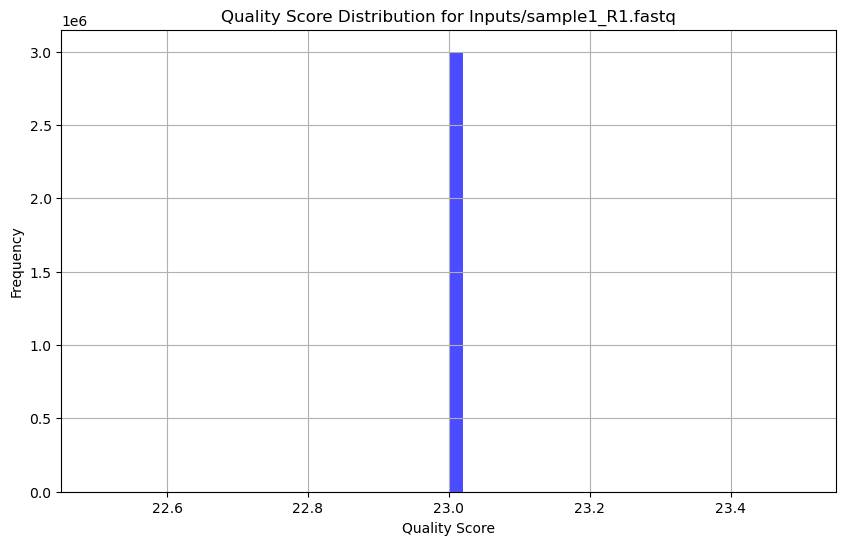

File: Inputs/sample1_R2.fastq, Number of reads: 19999
Quality scores (first 10): [23, 23, 23, 23, 23, 23, 23, 23, 23, 23]
Length of Quality scores: 2999850
Unique Quality Scores: {23}
Unique Read Lengths: {150}


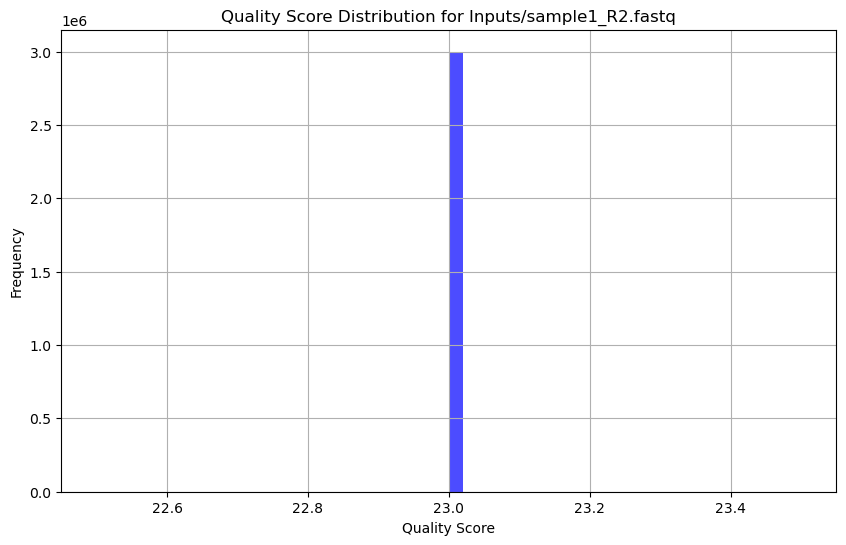

In [59]:
from Bio import SeqIO
import os

def assess_quality(file):
    all_scores = []
    read_lengths = []
    read_count = 0

    #parse fastq file
    for record in SeqIO.parse(file, 'fastq'):
        read_count += 1
        quality_scores = record.letter_annotations['phred_quality']
        all_scores.extend(quality_scores) ## need to understand why we use extend instead of append here
        read_lengths.append(len(quality_scores))
    return all_scores, read_lengths, read_count,


def plot_quality(qualities, file):
    plt.figure(figsize=(10, 6))
    plt.hist(qualities, bins=50, color='blue', alpha=0.7)
    plt.title(f'Quality Score Distribution for {file}')
    plt.xlabel('Quality Score')
    plt.ylabel('Frequency')
    plt.grid(True)
    #plt.savefig(f'{file_name}_quality_distribution.png') #change this to save in output
    plt.show()

# Example usage
file_path_1 = os.path.join('Inputs', 'sample1_R1.fastq')
file_path_2 = os.path.join('Inputs', 'sample1_R2.fastq')
input_fastqs = [file_path_1, file_path_2]

#best practice would be to only write out one:
for fastq_file in input_fastqs:
    qualities, read_length, read_count = assess_quality(fastq_file)
    print(f"File: {fastq_file}, Number of reads: {read_count}")
    print(f"Quality scores (first 10): {qualities[:10]}")
    print(f"Length of Quality scores: {len(qualities)}")
    print(f"Unique Quality Scores: {set(qualities)}")
    print(f"Unique Read Lengths: {set(read_length)}")
    plot_quality(qualities_1, f"{fastq_file}")

####### TO DO: OUTPUT PLOT_QUALITY TO FILE > CAN THEN DISCUSS IN REPORT ######

We see from outpus that, there are 19999 reads in each file, and all reads are 150bp in length and have a quality score at each base of 23 (equates to p= 0.00501, meaning 99.499% confident of each base at each position). This indicates the data is of very high quality and does not need to be trimmed (also assuming there are no adaptors on the reads)- In reality I would consider this dataset to have already been trimmed or that it is a synthetic dataset. Given the uniform quality scores I'd assume the latter. We could continue to check GC content as an extra measure of sequence quality. why? what does GC content mean for RNAseq reads?

#############################

Quality good + ?no adaptors needing to be trimmed > move on.
Download ref sequence - using RNA-seq data we could either align to genome or transcriptome. Pros/cons to each in word document. Lets do a quick online alignment to see if we have splice variants that dont align if this is the case use genome for comprehensive alignment. If not and all proteins are routine > go with transcriptome, less memory increased speed and efficiency. HOWEVER if you do this, rationalize why we used transcriptome (speed/efficiency, good for quantification of known transcripts (not novel), human genome is very well annotated therefore starting with transcriptome alignment is an efficient first step [remember we are only analyzing the first sample from Dr. Herrera to gain preliminary insights into gene expression]). 

So to do a quick check online. lets gather all unique sequences > save as fasta > run ALIGNMENT.

In [ ]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq

def find_unique_sequences_and_write_fasta(fastq_file, fasta_file):
    unique_sequences = set()
    sequence_id = 1
    
    with open(fastq_file, "r") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            sequence = str(record.seq)
            if sequence not in unique_sequences:
                unique_sequences.add(sequence)
    
    with open(fasta_file, "w") as output_handle:
        for sequence in unique_sequences:
            seq_record = SeqRecord(Seq(sequence), id=f"seq{sequence_id}", description="")
            SeqIO.write(seq_record, output_handle, "fasta")
            sequence_id += 1

# Example usage
fastq_file = os.path.join('Inputs', 'sample1_R1.fastq')
fasta_file = 'unique_sequences_R1.fasta'
find_unique_sequences_and_write_fasta(fastq_file, fasta_file)